In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from statistics import mean, stdev 

In [9]:
df = pd.read_csv('/content/imagedata.csv')
df = df.drop(columns=['Unnamed: 0'])
image0 = cv2.imread('/content/WhatsApp Image 2021-05-15 at 6.31.52 PM (1).jpeg')

# **Augmentation for Mask Images to equalize the proportionate**

In [10]:
x_mask = df[df['Label']==1].iloc[:,:-1].to_numpy()
y_mask = df[df['Label']==1].iloc[:,-1].to_numpy()

x_augment = []
y_augment = []

for image, label in zip(x_mask, y_mask):
  image = image.reshape(64,64) 
  x_augment.append((np.fliplr(image)).reshape([-1]))
  y_augment.append(label)

shuffle_idx = np.random.permutation(len(x_augment))
x_augment = np.array(x_augment)[shuffle_idx]
y_augment = np.array(y_augment)[shuffle_idx]

x_aug = pd.DataFrame(x_augment,columns=df.iloc[:,:-1].columns)
x_aug['Label'] = y_augment
df = pd.concat([df,x_aug])
df = df.reset_index()
df = df.sample(frac=1)
df = df.drop(columns=['index'])

# **Augmentation of each image by adding its counterpart with Randomized Gaussian Noises**

In [11]:
x_orig = df.iloc[:,:-1].to_numpy()
y_orig = df.iloc[:,-1].to_numpy()

x_augmented = [image for image in x_orig]
y_augmented = [label for label in y_orig]

for image, label in zip(x_orig, y_orig):
  image = image.reshape(64,64) 
  x_augmented.append(255*(random_noise(image)).reshape([-1]))
  y_augmented.append(label)

shuffle_id = np.random.permutation(len(x_augmented))
x_augmented = np.array(x_augmented)[shuffle_id]
y_augmented = np.array(y_augmented)[shuffle_id]

df = pd.DataFrame(x_augmented,columns=df.iloc[:,:-1].columns)
df['Label'] = y_augmented
df = df.sample(frac=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10470 entries, 4973 to 6664
Columns: 4097 entries, 0 to Label
dtypes: float64(4096), int64(1)
memory usage: 327.3 MB


In [13]:
df.describe()

0             1  ...          4095         Label
count  10470.000000  10470.000000  ...  10470.000000  10470.000000
mean      42.601538     41.168894  ...     60.196121      0.524928
std       56.555434     54.467902  ...     74.680263      0.499402
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.000000      0.000000  ...      0.000000      0.000000
50%       23.000000     22.996711  ...     25.577693      1.000000
75%       55.000000     54.000000  ...     99.000000      1.000000
max      255.000000    255.000000  ...    255.000000      1.000000

[8 rows x 4097 columns]

In [14]:
#Check for missing value
print(df.isnull())
print(df.isnull().sum())

          0      1      2      3      4  ...   4092   4093   4094   4095  Label
4973  False  False  False  False  False  ...  False  False  False  False  False
4944  False  False  False  False  False  ...  False  False  False  False  False
9760  False  False  False  False  False  ...  False  False  False  False  False
4401  False  False  False  False  False  ...  False  False  False  False  False
8462  False  False  False  False  False  ...  False  False  False  False  False
...     ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
469   False  False  False  False  False  ...  False  False  False  False  False
9073  False  False  False  False  False  ...  False  False  False  False  False
1991  False  False  False  False  False  ...  False  False  False  False  False
5673  False  False  False  False  False  ...  False  False  False  False  False
6664  False  False  False  False  False  ...  False  False  False  False  False

[10470 rows x 4097 columns]
0        0


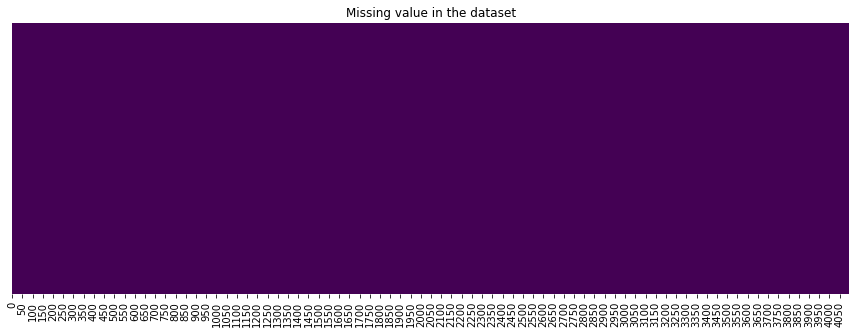

In [15]:
import seaborn as sns
plt.figure(figsize=(15,5))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

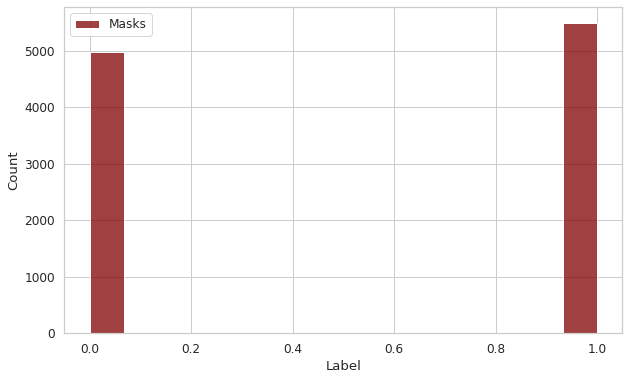

In [16]:
import seaborn as sns
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 6]})
sns.histplot(data = df, x="Label", color="maroon", label="Masks")
plt.legend() 
plt.show()

# **Train-Test Split according to the mentioned 50-50 Ratio**

In [17]:
X=df.iloc[:,:-1]
Y=df.iloc[:,-1]

In [18]:
x_tr,x_te,y_tr,y_te = train_test_split(X,Y,test_size=0.5,random_state= 42)

# **Different Classifiers**

## Multi-Layer Perceptron

In [19]:
accuracies=[]

In [20]:
model_mlp = MLPC(hidden_layer_sizes=(100,50,25,),max_iter=200,tol=0.0000001)
model_mlp.fit(x_tr,y_tr)
print(model_mlp.score(x_te,y_te))
accuracies.append(model_mlp.score(x_te,y_te))

0.6970391595033428


In [21]:
print(classification_report(y_te,model_mlp.predict(x_te)))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66      2491
           1       0.69      0.76      0.73      2744

    accuracy                           0.70      5235
   macro avg       0.70      0.69      0.69      5235
weighted avg       0.70      0.70      0.70      5235



[[1554  937]
 [ 649 2095]]


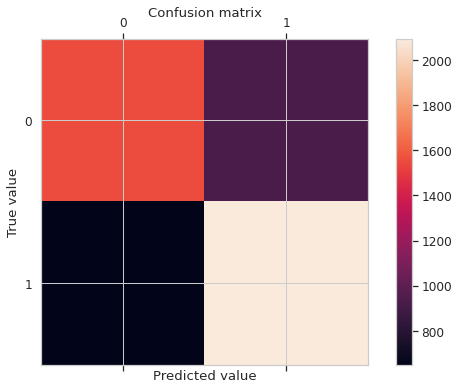

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_te, model_mlp.predict(x_te))
print(cm)
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111) 
cax = ax.matshow(cm) 
plt.title('Confusion matrix') 
fig.colorbar(cax) 
ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
plt.xlabel('Predicted value') 
plt.ylabel('True value') 
plt.show()

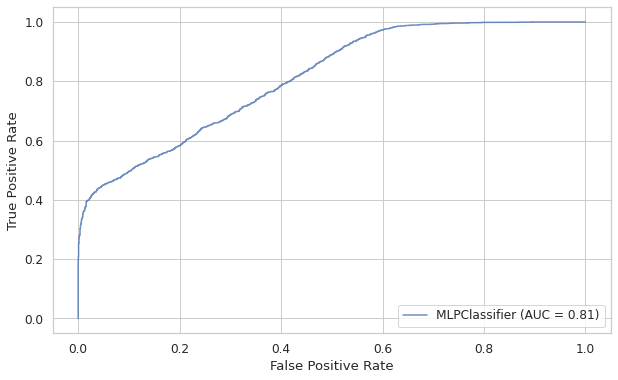

In [23]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp1 = plot_roc_curve(model_mlp, x_te, y_te, ax=ax, alpha=0.8)
plt.show()

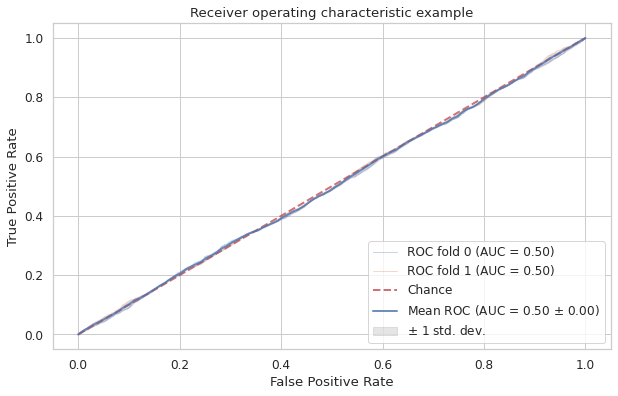

List of all accuracies obtained: [48.99713467048711, 52.110792741165234]

Maximum Accuracy that can be obtained from this model is: 52.110792741165234 %

Minimum Accuracy that can be obtained from this model is: 48.99713467048711 %

Overall Accuracy: 50.55396370582617 %

Standard Deviation is: 2.201688736072726


In [24]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
lst_accu_stratified = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)): 
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y[train_index], Y[test_index] 
    model_mlp.fit(X_train_fold, Y_train_fold) 
    lst_accu_stratified.append(model_mlp.score(X_test_fold, Y_test_fold)*100)
    viz = plot_roc_curve(model_mlp, X_test_fold, Y_test_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()
print('List of all accuracies obtained:', lst_accu_stratified) 
print('\nMaximum Accuracy that can be obtained from this model is:', 
      max(lst_accu_stratified), '%') 
print('\nMinimum Accuracy that can be obtained from this model is:', 
      min(lst_accu_stratified), '%') 
print('\nOverall Accuracy:', 
      mean(lst_accu_stratified), '%') 
print('\nStandard Deviation is:', stdev(lst_accu_stratified)) 

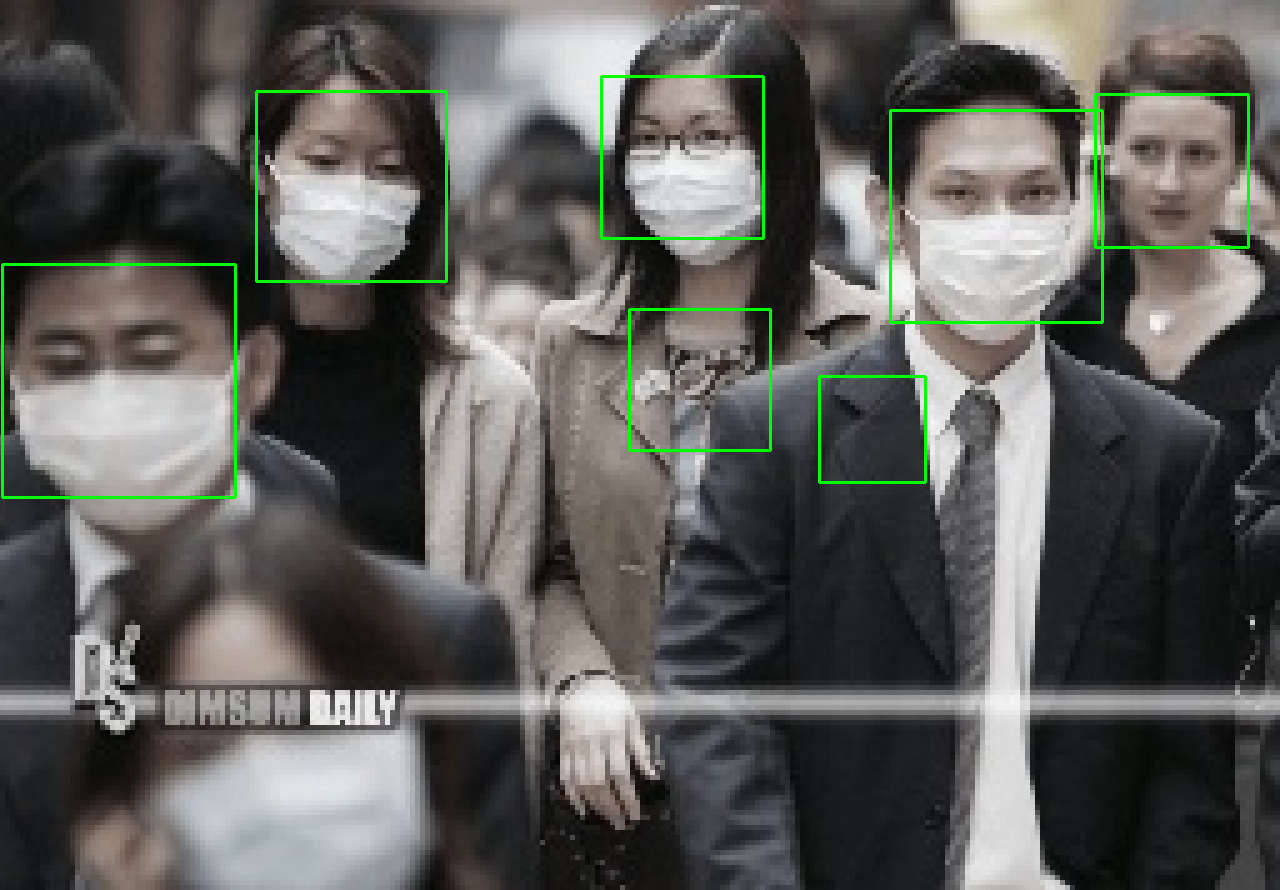

In [25]:
image1 = cv2.resize(image0,(0,0),fx=5,fy=5,interpolation = cv2.INTER_AREA)
kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
image = cv2.filter2D(image1, -1, kernel)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(gray)

for (x, y, w, h) in faces:
  test = cv2.resize(image1[y:y+h,x:x+w],(64,64))
  test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
  test = test.reshape(-1)
  cla = model_mlp.predict(test.reshape(1,-1))
  if cla==0:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 0, 255), 2)
    #print("No Mask\n")
  else:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #print("Mask\n")
cv2_imshow(image1)

## Random Forest Classifier

In [26]:
model_rfc = RFC(n_jobs=-1)
model_rfc.fit(x_tr,y_tr)
print(model_rfc.score(x_te,y_te))
accuracies.append(model_rfc.score(x_te,y_te))

0.7176695319961796


In [28]:
print(classification_report(y_te,model_rfc.predict(x_te)))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      2491
           1       0.73      0.74      0.73      2744

    accuracy                           0.72      5235
   macro avg       0.72      0.72      0.72      5235
weighted avg       0.72      0.72      0.72      5235



[[1723  768]
 [ 710 2034]]


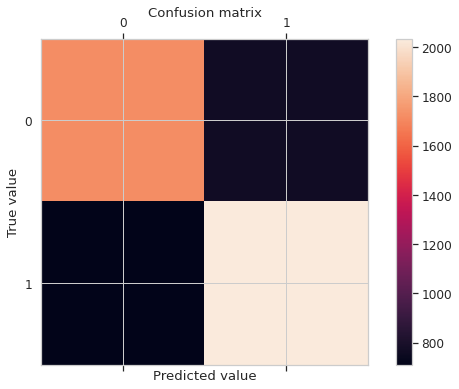

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_te, model_rfc.predict(x_te))
print(cm)
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111) 
cax = ax.matshow(cm) 
plt.title('Confusion matrix') 
fig.colorbar(cax) 
ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
plt.xlabel('Predicted value') 
plt.ylabel('True value') 
plt.show()

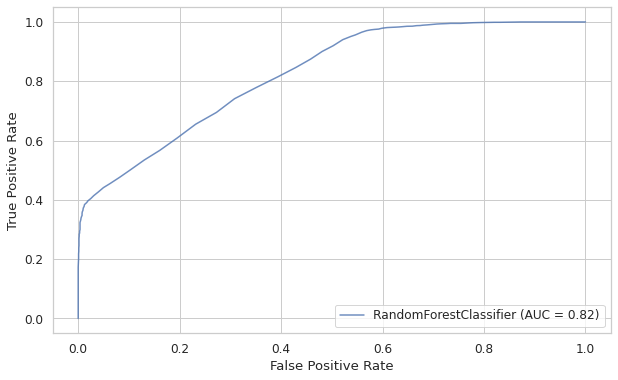

In [30]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp2 = plot_roc_curve(model_rfc, x_te, y_te, ax=ax, alpha=0.8)
plt.show()

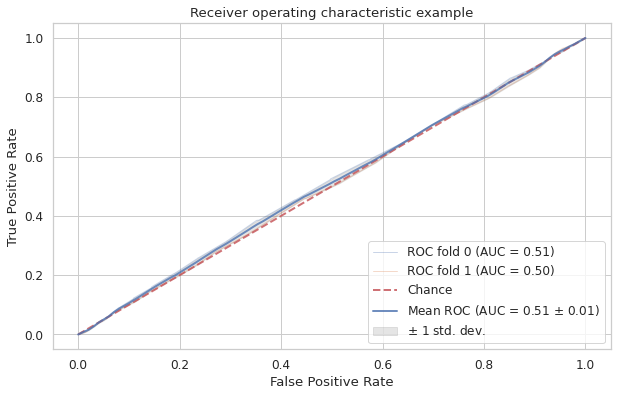

List of all accuracies obtained: [51.32760267430755, 50.71633237822349]

Maximum Accuracy that can be obtained from this model is: 51.32760267430755 %

Minimum Accuracy that can be obtained from this model is: 50.71633237822349 %

Overall Accuracy: 51.02196752626552 %

Standard Deviation is: 0.4322333714989461


In [31]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
lst_accu_stratified = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)): 
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y[train_index], Y[test_index] 
    model_rfc.fit(X_train_fold, Y_train_fold) 
    lst_accu_stratified.append(model_rfc.score(X_test_fold, Y_test_fold)*100)
    viz = plot_roc_curve(model_rfc, X_test_fold, Y_test_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()
print('List of all accuracies obtained:', lst_accu_stratified) 
print('\nMaximum Accuracy that can be obtained from this model is:', 
      max(lst_accu_stratified), '%') 
print('\nMinimum Accuracy that can be obtained from this model is:', 
      min(lst_accu_stratified), '%') 
print('\nOverall Accuracy:', 
      mean(lst_accu_stratified), '%') 
print('\nStandard Deviation is:', stdev(lst_accu_stratified)) 

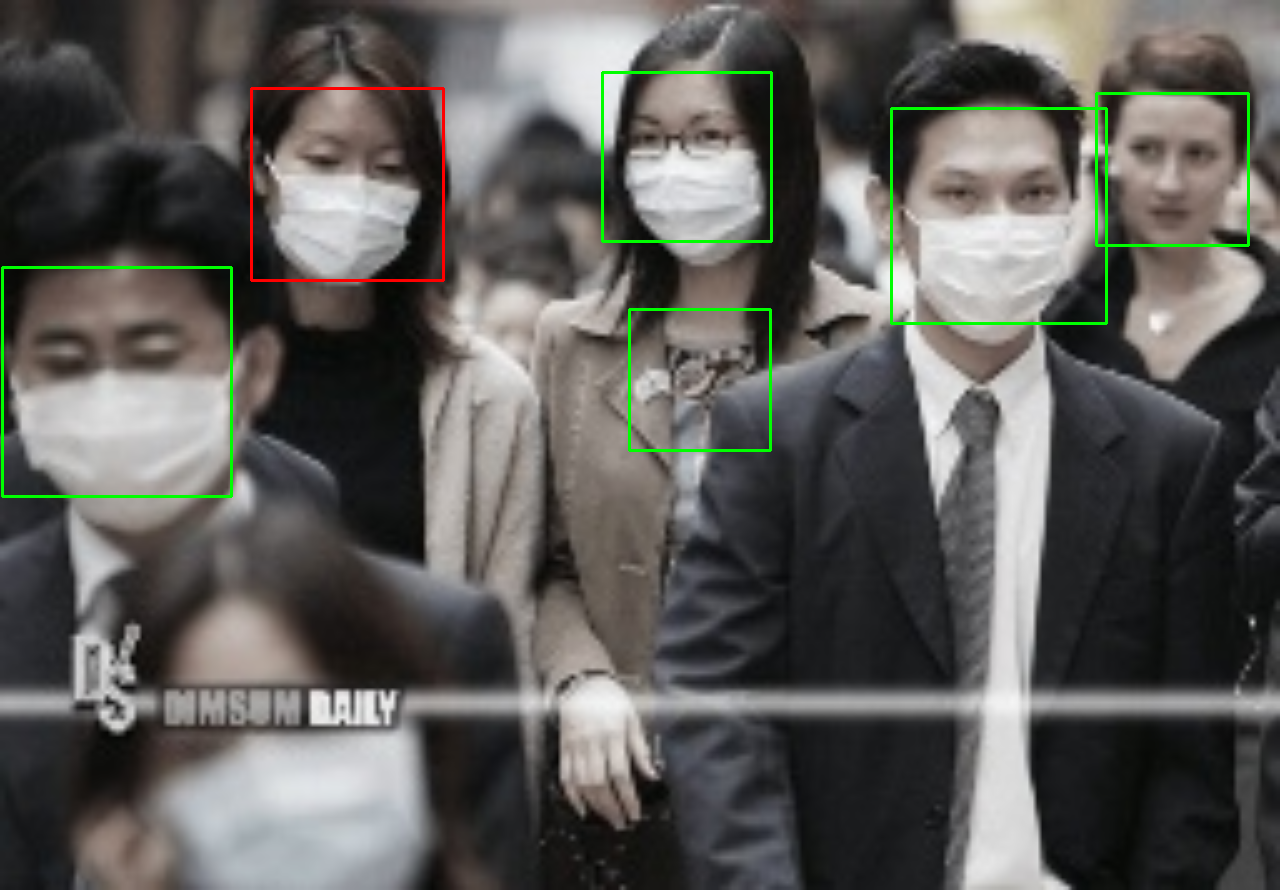

In [32]:
image1 = cv2.resize(image0,(0,0),fx=5,fy=5)
kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
image = cv2.filter2D(image1, -1, kernel)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(gray)

for (x, y, w, h) in faces:
  cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
  test = cv2.resize(image1[y:y+h,x:x+w],(64,64))
  test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
  test = test.reshape(-1)
  cla = model_rfc.predict(test.reshape(1,-1))
  if cla==0:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 0, 255), 2)
    #print("No Mask\n")
  else:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #print("Mask\n")
cv2_imshow(image1)

## Decision Tree Classifier

In [33]:
model_dtc = DTC()
model_dtc.fit(x_tr,y_tr)
print(model_dtc.score(x_te,y_te))
accuracies.append(model_dtc.score(x_te,y_te))

0.6657115568290354


In [34]:
print(classification_report(y_te,model_dtc.predict(x_te)))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2491
           1       0.68      0.68      0.68      2744

    accuracy                           0.67      5235
   macro avg       0.67      0.67      0.67      5235
weighted avg       0.67      0.67      0.67      5235



[[1626  865]
 [ 885 1859]]


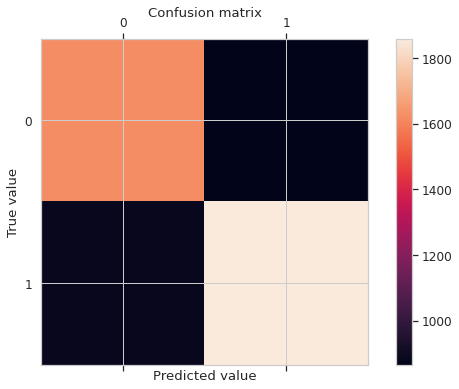

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_te, model_dtc.predict(x_te))
print(cm)
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111) 
cax = ax.matshow(cm) 
plt.title('Confusion matrix') 
fig.colorbar(cax) 
ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
plt.xlabel('Predicted value') 
plt.ylabel('True value') 
plt.show()

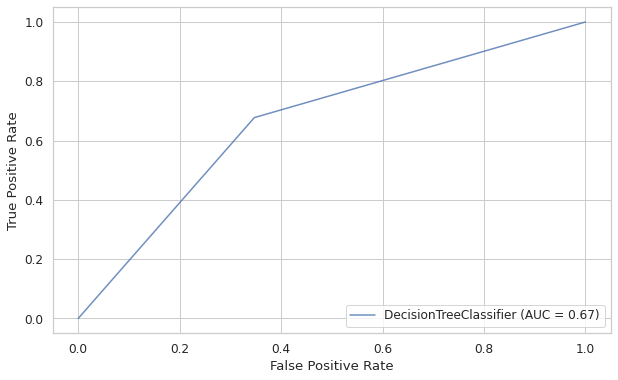

In [36]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp3 = plot_roc_curve(model_dtc, x_te, y_te, ax=ax, alpha=0.8)
plt.show()

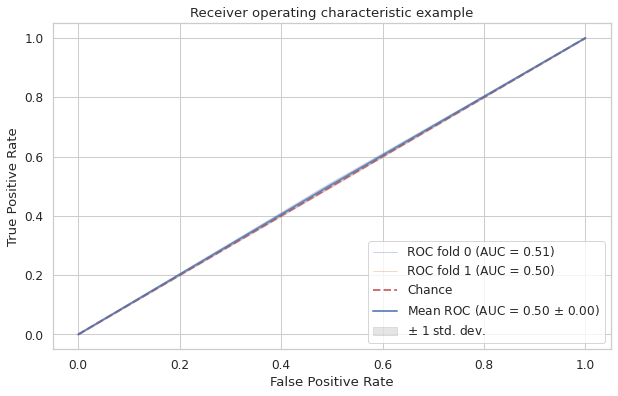

List of all accuracies obtained: [50.678127984718245, 50.066857688634194]

Maximum Accuracy that can be obtained from this model is: 50.678127984718245 %

Minimum Accuracy that can be obtained from this model is: 50.066857688634194 %

Overall Accuracy: 50.372492836676216 %

Standard Deviation is: 0.43223337149894103


In [37]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
lst_accu_stratified = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)): 
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y[train_index], Y[test_index] 
    model_dtc.fit(X_train_fold, Y_train_fold) 
    lst_accu_stratified.append(model_dtc.score(X_test_fold, Y_test_fold)*100)
    viz = plot_roc_curve(model_dtc, X_test_fold, Y_test_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()
print('List of all accuracies obtained:', lst_accu_stratified) 
print('\nMaximum Accuracy that can be obtained from this model is:', 
      max(lst_accu_stratified), '%') 
print('\nMinimum Accuracy that can be obtained from this model is:', 
      min(lst_accu_stratified), '%') 
print('\nOverall Accuracy:', 
      mean(lst_accu_stratified), '%') 
print('\nStandard Deviation is:', stdev(lst_accu_stratified)) 

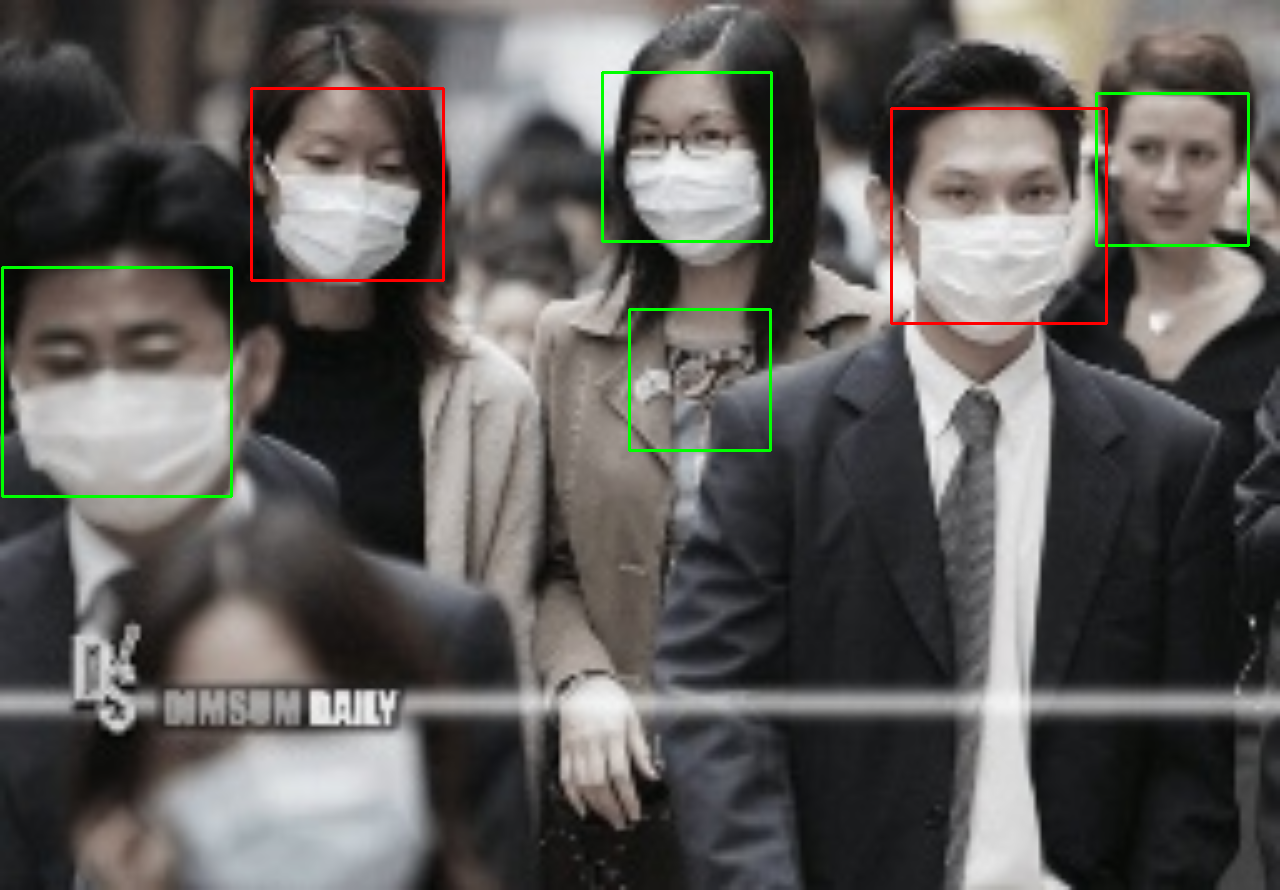

In [38]:
image1 = cv2.resize(image0,(0,0),fx=5,fy=5)
kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
image = cv2.filter2D(image1, -1, kernel)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(gray)

for (x, y, w, h) in faces:
  cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
  test = cv2.resize(image1[y:y+h,x:x+w],(64,64))
  test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
  test = test.reshape(-1)
  cla = model_dtc.predict(test.reshape(1,-1))
  if cla==0:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 0, 255), 2)
    #print("No Mask\n")
  else:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #print("Mask\n")
cv2_imshow(image1)

## Logistic Regression

In [39]:
lr=LogisticRegression(n_jobs=-1)
lr.fit(x_tr,y_tr)
y_pred = lr.predict(x_te)
accuracies.append(lr.score(x_te,y_te))

In [40]:
print(classification_report(y_te,lr.predict(x_te)))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      2491
           1       0.64      0.64      0.64      2744

    accuracy                           0.62      5235
   macro avg       0.62      0.62      0.62      5235
weighted avg       0.62      0.62      0.62      5235



[[1488 1003]
 [ 987 1757]]


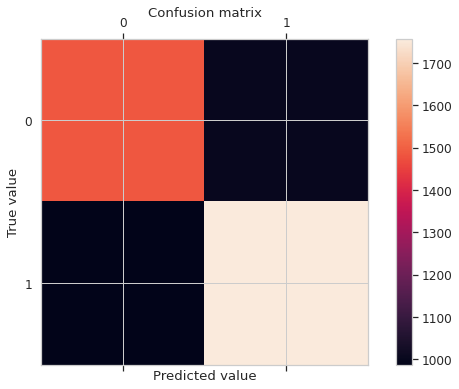

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_te, y_pred)
print(cm)
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111) 
cax = ax.matshow(cm) 
plt.title('Confusion matrix') 
fig.colorbar(cax) 
ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
plt.xlabel('Predicted value') 
plt.ylabel('True value') 
plt.show()

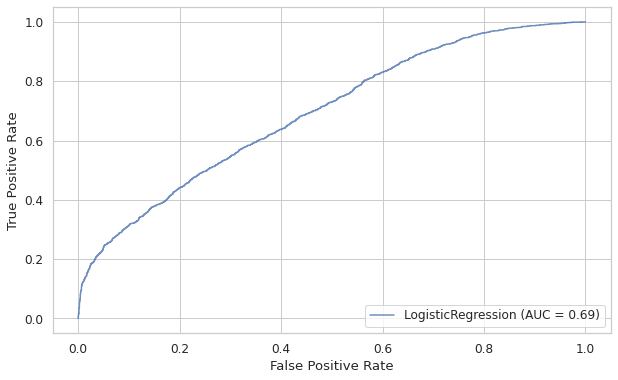

In [42]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp4 = plot_roc_curve(lr, x_te, y_te, ax=ax, alpha=0.8)
plt.show()

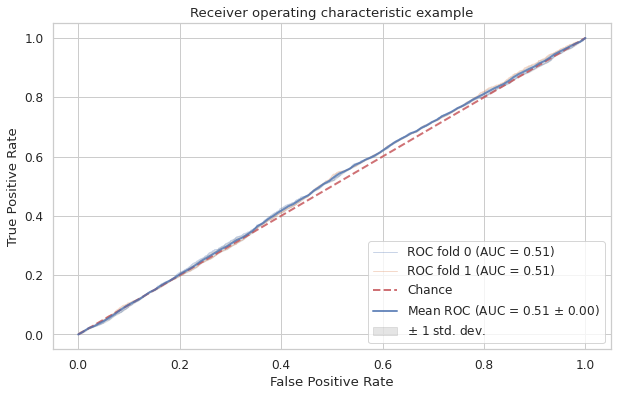

List of all accuracies obtained: [51.06017191977077, 51.76695319961796]

Maximum Accuracy that can be obtained from this model is: 51.76695319961796 %

Minimum Accuracy that can be obtained from this model is: 51.06017191977077 %

Overall Accuracy: 51.41356255969436 %

Standard Deviation is: 0.49976983579565637


In [43]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
lst_accu_stratified = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)): 
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y[train_index], Y[test_index] 
    lr.fit(X_train_fold, Y_train_fold) 
    lst_accu_stratified.append(lr.score(X_test_fold, Y_test_fold)*100)
    viz = plot_roc_curve(lr, X_test_fold, Y_test_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()
print('List of all accuracies obtained:', lst_accu_stratified) 
print('\nMaximum Accuracy that can be obtained from this model is:', 
      max(lst_accu_stratified), '%') 
print('\nMinimum Accuracy that can be obtained from this model is:', 
      min(lst_accu_stratified), '%') 
print('\nOverall Accuracy:', 
      mean(lst_accu_stratified), '%') 
print('\nStandard Deviation is:', stdev(lst_accu_stratified)) 

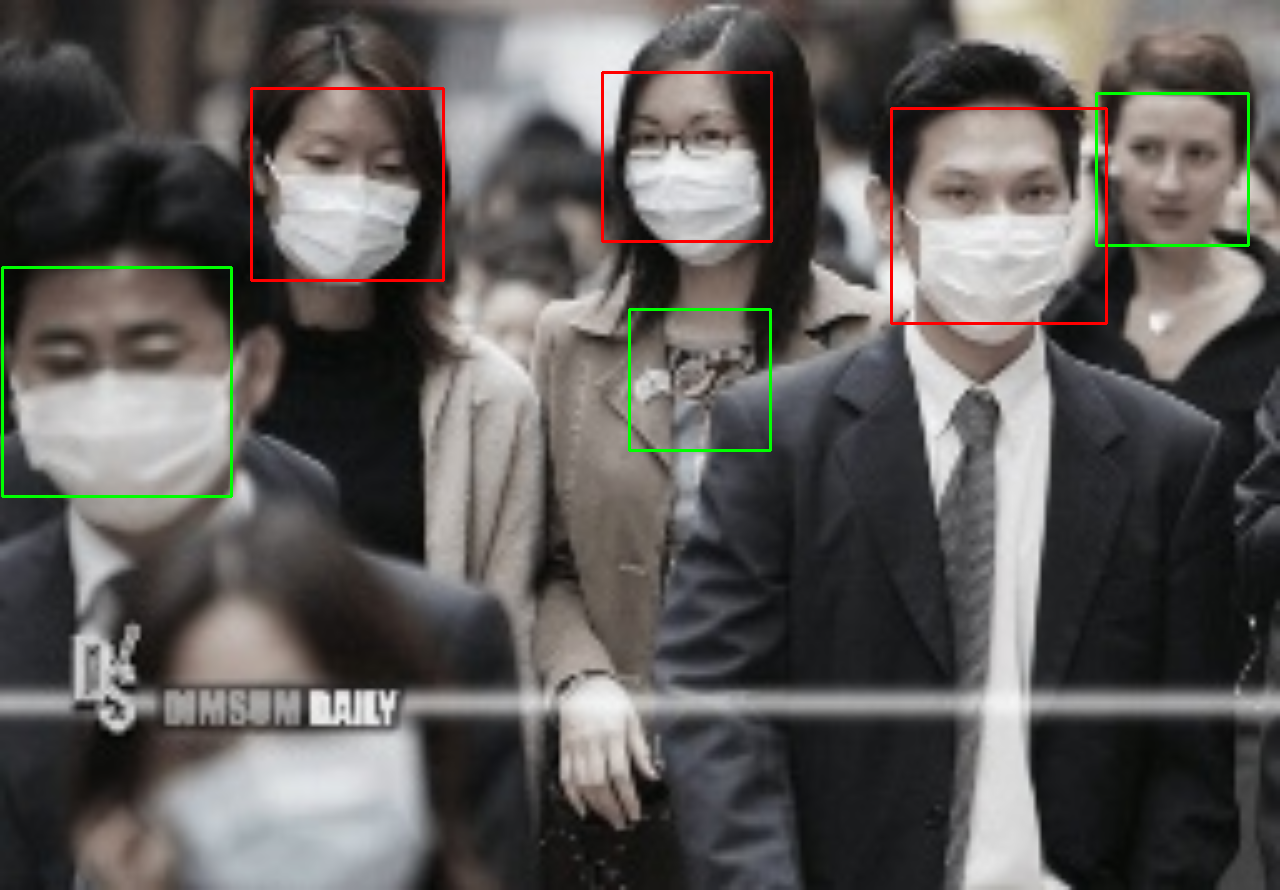

In [44]:
image1 = cv2.resize(image0,(0,0),fx=5,fy=5)
kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
image = cv2.filter2D(image1, -1, kernel)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(gray)

for (x, y, w, h) in faces:
  cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
  test = cv2.resize(image1[y:y+h,x:x+w],(64,64))
  test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
  test = test.reshape(-1)
  cla = lr.predict(test.reshape(1,-1))
  if cla==0:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 0, 255), 2)
    #print("No Mask\n")
  else:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #print("Mask\n")
cv2_imshow(image1)

## Gaussian Naive Bayes

In [45]:
gnb = GaussianNB()
gnb.fit(x_tr,y_tr)
y_pred =  gnb.predict(x_te)
accuracies.append(gnb.score(x_te,y_te))

In [46]:
print(classification_report(y_te,gnb.predict(x_te)))

              precision    recall  f1-score   support

           0       0.63      0.45      0.52      2491
           1       0.60      0.76      0.67      2744

    accuracy                           0.61      5235
   macro avg       0.61      0.60      0.60      5235
weighted avg       0.61      0.61      0.60      5235



[[1122 1369]
 [ 672 2072]]


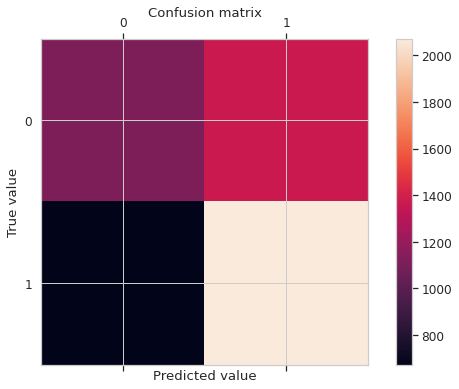

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_te, y_pred)
print(cm)
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111) 
cax = ax.matshow(cm) 
plt.title('Confusion matrix') 
fig.colorbar(cax) 
ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
plt.xlabel('Predicted value') 
plt.ylabel('True value') 
plt.show()

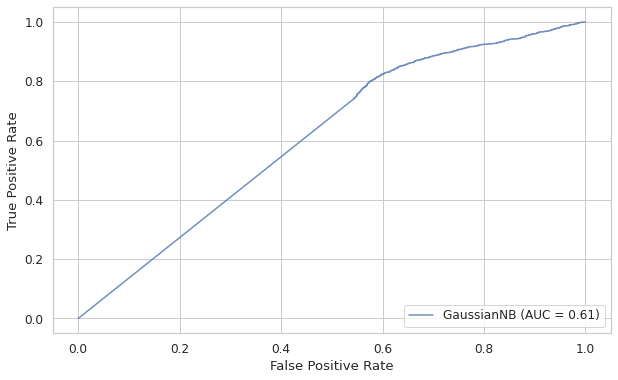

In [48]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp1 = plot_roc_curve(gnb, x_te, y_te, ax=ax, alpha=0.8)
plt.show()

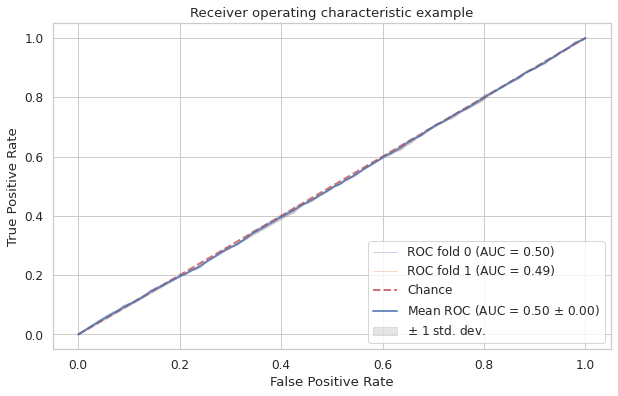

List of all accuracies obtained: [51.136580706781274, 49.436485195797516]

Maximum Accuracy that can be obtained from this model is: 51.136580706781274 %

Minimum Accuracy that can be obtained from this model is: 49.436485195797516 %

Overall Accuracy: 50.286532951289395 %

Standard Deviation is: 1.2021490644814237


In [49]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
lst_accu_stratified = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)): 
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y[train_index], Y[test_index] 
    gnb.fit(X_train_fold, Y_train_fold) 
    lst_accu_stratified.append(gnb.score(X_test_fold, Y_test_fold)*100)
    viz = plot_roc_curve(gnb, X_test_fold, Y_test_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()
print('List of all accuracies obtained:', lst_accu_stratified) 
print('\nMaximum Accuracy that can be obtained from this model is:', 
      max(lst_accu_stratified), '%') 
print('\nMinimum Accuracy that can be obtained from this model is:', 
      min(lst_accu_stratified), '%') 
print('\nOverall Accuracy:', 
      mean(lst_accu_stratified), '%') 
print('\nStandard Deviation is:', stdev(lst_accu_stratified)) 

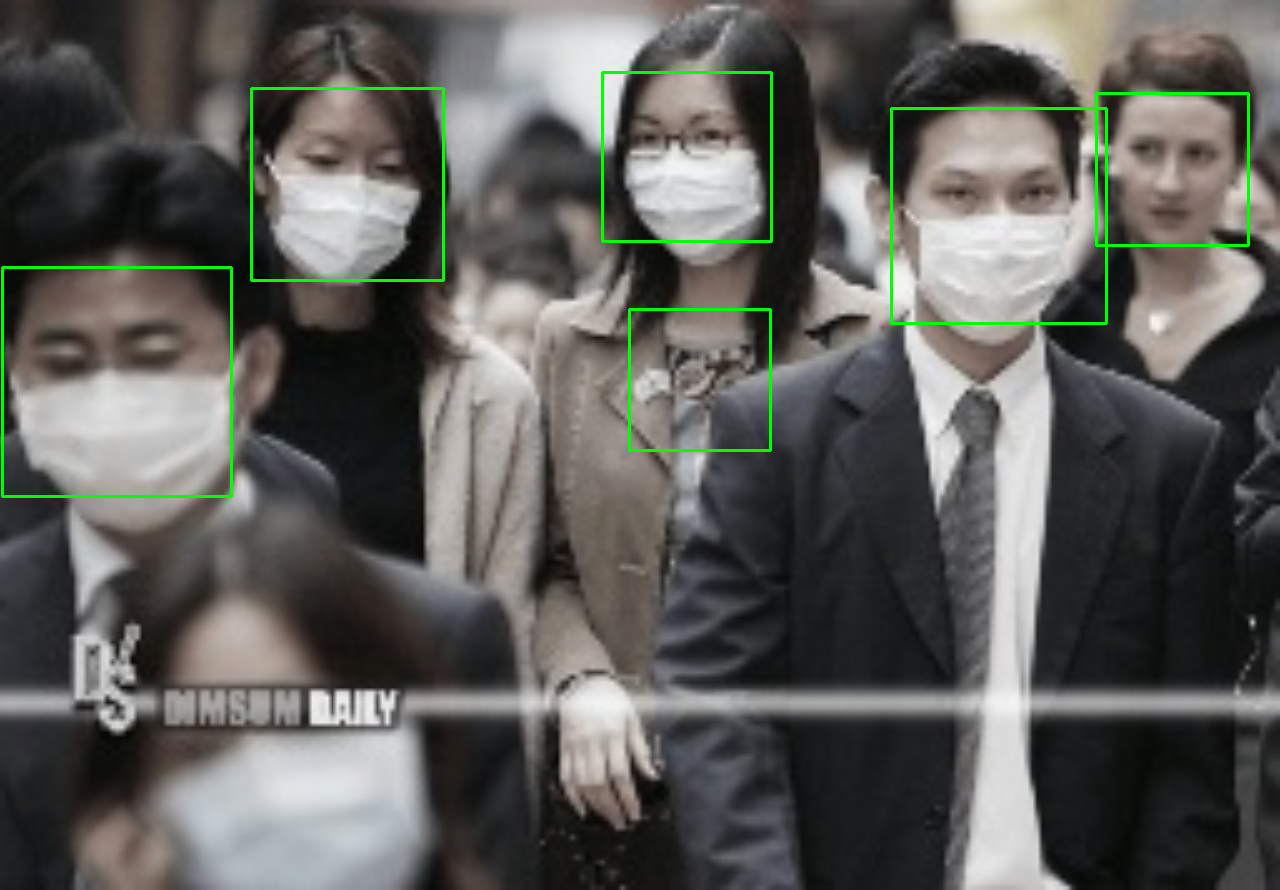

In [50]:
image1 = cv2.resize(image0,(0,0),fx=5,fy=5)
kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
image = cv2.filter2D(image1, -1, kernel)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(gray)

for (x, y, w, h) in faces:
  cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
  test = cv2.resize(image1[y:y+h,x:x+w],(64,64))
  test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
  test = test.reshape(-1)
  cla = gnb.predict(test.reshape(1,-1))
  if cla==0:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 0, 255), 2)
    #print("No Mask\n")
  else:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #print("Mask\n")
cv2_imshow(image1)

## KNN

In [51]:
knn = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
knn.fit(x_tr,y_tr)
y_pred= knn.predict(x_te) 
accuracies.append(knn.score(x_te,y_te))

In [52]:
print(classification_report(y_te,knn.predict(x_te)))

              precision    recall  f1-score   support

           0       0.72      0.57      0.64      2491
           1       0.67      0.80      0.73      2744

    accuracy                           0.69      5235
   macro avg       0.70      0.68      0.68      5235
weighted avg       0.69      0.69      0.69      5235



[[1421 1070]
 [ 553 2191]]


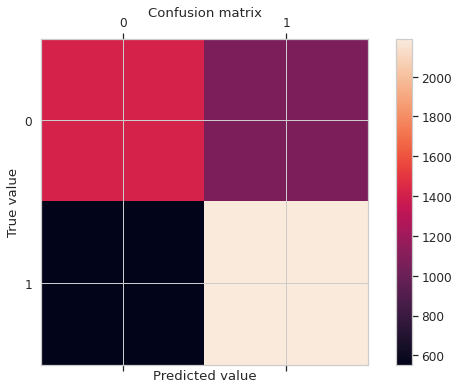

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_te, y_pred)
print(cm)
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111) 
cax = ax.matshow(cm) 
plt.title('Confusion matrix') 
fig.colorbar(cax) 
ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
plt.xlabel('Predicted value') 
plt.ylabel('True value') 
plt.show()

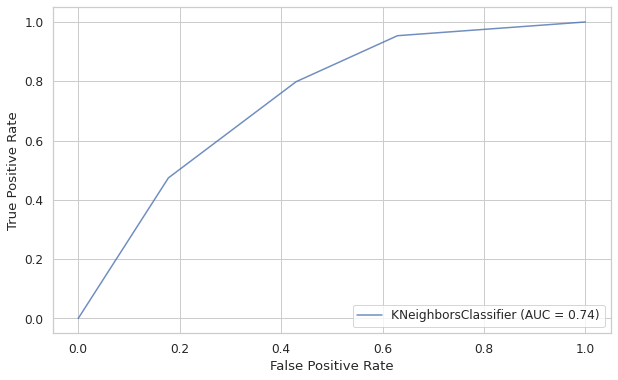

In [54]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp1 = plot_roc_curve(knn, x_te, y_te, ax=ax, alpha=0.8)
plt.show()

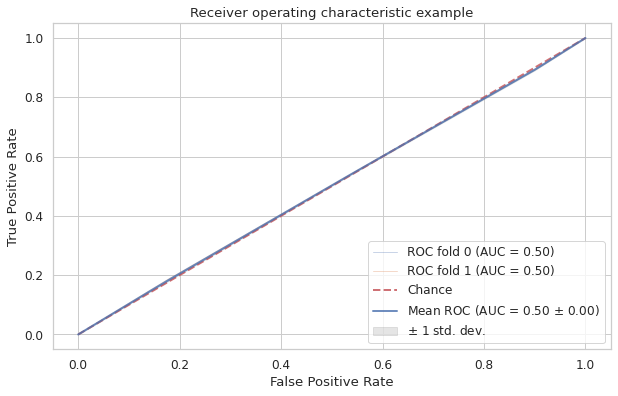

List of all accuracies obtained: [50.296084049665716, 50.41069723018147]

Maximum Accuracy that can be obtained from this model is: 50.41069723018147 %

Minimum Accuracy that can be obtained from this model is: 50.296084049665716 %

Overall Accuracy: 50.35339063992359 %

Standard Deviation is: 0.08104375715604736


In [55]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
lst_accu_stratified = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)): 
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y[train_index], Y[test_index] 
    knn.fit(X_train_fold, Y_train_fold) 
    lst_accu_stratified.append(knn.score(X_test_fold, Y_test_fold)*100)
    viz = plot_roc_curve(knn, X_test_fold, Y_test_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()
print('List of all accuracies obtained:', lst_accu_stratified) 
print('\nMaximum Accuracy that can be obtained from this model is:', 
      max(lst_accu_stratified), '%') 
print('\nMinimum Accuracy that can be obtained from this model is:', 
      min(lst_accu_stratified), '%') 
print('\nOverall Accuracy:', 
      mean(lst_accu_stratified), '%') 
print('\nStandard Deviation is:', stdev(lst_accu_stratified)) 

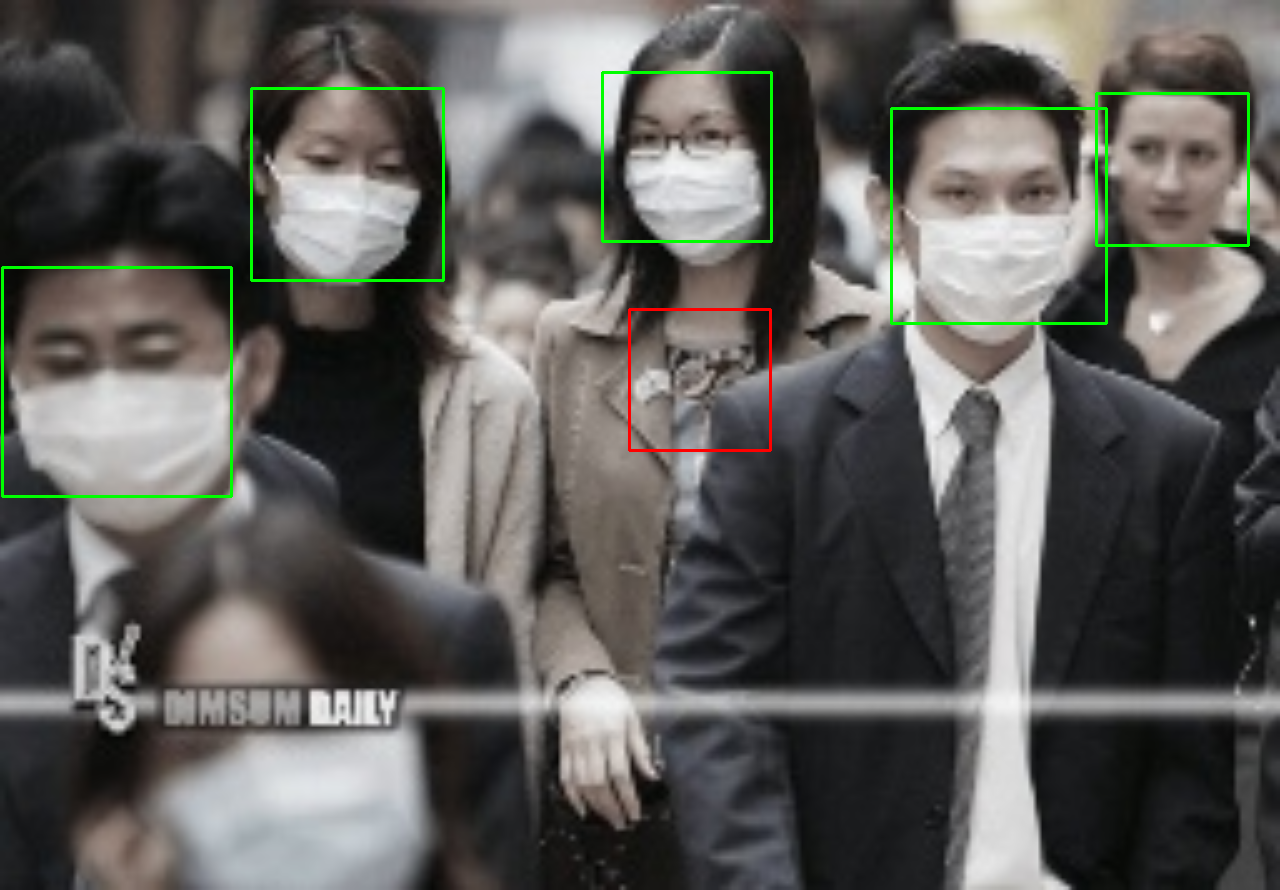

In [56]:
image1 = cv2.resize(image0,(0,0),fx=5,fy=5)
kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
image = cv2.filter2D(image1, -1, kernel)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(gray)

for (x, y, w, h) in faces:
  cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
  test = cv2.resize(image1[y:y+h,x:x+w],(64,64))
  test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
  test = test.reshape(-1)
  cla = knn.predict(test.reshape(1,-1))
  if cla==0:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 0, 255), 2)
    #print("No Mask\n")
  else:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #print("Mask\n")
cv2_imshow(image1)

## SVM

In [57]:
svc = SVC(C=30, kernel='rbf')
svc.fit(x_tr,y_tr)
y_pred=svc.predict(x_te)
accuracies.append(svc.score(x_te,y_te))

In [58]:
print(classification_report(y_te,svc.predict(x_te)))

              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2491
           1       0.73      0.72      0.72      2744

    accuracy                           0.71      5235
   macro avg       0.71      0.71      0.71      5235
weighted avg       0.71      0.71      0.71      5235



[[1767  724]
 [ 774 1970]]


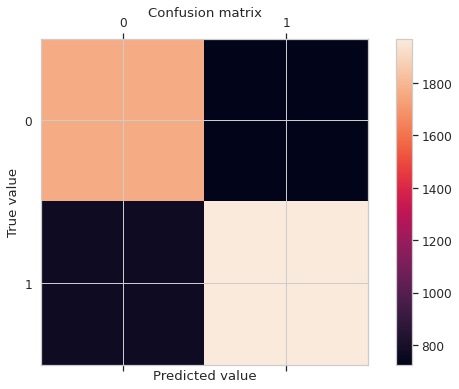

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_te, y_pred)
print(cm)
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111) 
cax = ax.matshow(cm) 
plt.title('Confusion matrix') 
fig.colorbar(cax) 
ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
plt.xlabel('Predicted value') 
plt.ylabel('True value') 
plt.show()

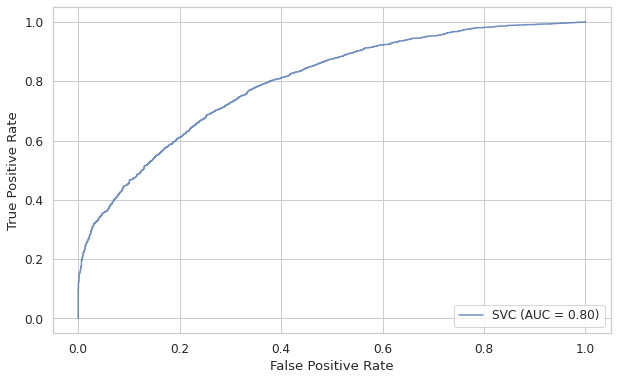

In [60]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp5 = plot_roc_curve(svc, x_te, y_te, ax=ax, alpha=0.8)
plt.show()

In [ ]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
lst_accu_stratified = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)): 
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y[train_index], Y[test_index] 
    svc.fit(X_train_fold, Y_train_fold) 
    lst_accu_stratified.append(svc.score(X_test_fold, Y_test_fold)*100)
    viz = plot_roc_curve(svc, X_test_fold, Y_test_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()
print('List of all accuracies obtained:', lst_accu_stratified) 
print('\nMaximum Accuracy that can be obtained from this model is:', 
      max(lst_accu_stratified), '%') 
print('\nMinimum Accuracy that can be obtained from this model is:', 
      min(lst_accu_stratified), '%') 
print('\nOverall Accuracy:', 
      mean(lst_accu_stratified), '%') 
print('\nStandard Deviation is:', stdev(lst_accu_stratified)) 

In [ ]:
image1 = cv2.resize(image0,(0,0),fx=5,fy=5)
kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
image = cv2.filter2D(image1, -1, kernel)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(gray)

for (x, y, w, h) in faces:
  cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
  test = cv2.resize(image1[y:y+h,x:x+w],(64,64))
  test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
  test = test.reshape(-1)
  cla = svc.predict(test.reshape(1,-1))
  if cla==0:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 0, 255), 2)
    #print("No Mask\n")
  else:
    cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #print("Mask\n")
cv2_imshow(image1)

# Box plots comparing all the models

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
models = {'rf':RFC(),'lr':LogisticRegression(),'gnb':GaussianNB(),'mlp':MLPC(),'svc':SVC(kernel = 'rbf'),'knn':KNeighborsClassifier(),'dtc':DTC()}
results=[]
names=[]

for name, model in models.items():
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
  print(scores)
print(names)
print(scores)

In [ ]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
fitmodel = [model_mlp, model_rfc, model_dtc, lr, gnb, knn, svc]
Models = ['MLP','Random Forest','Decision Tree','Logistic Regression','Gaussian Naive Bayes','KNN', 'SVM']


In [ ]:
plt.figure(figsize = (20,10))
ax = plt.subplot(121)
plt.plot(Models,accuracies,marker='o')
plt.legend(labels = ['Models','Accuracy'])
plt.title('Comparison of accuracies of different models')